# Simulação simples

In [9]:
import os
import sys
import numpy as np
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()

agent_list = os.listdir('agents')

print(agent_list)

sys.path.insert(0, 'agents')
sys.path.insert(0, 'environments')

['ps_agent_basic.py', 'ps_agent_flexible.py', '__pycache__']


In [34]:
import env_abp_target_finding as env

L = 100

Pe = 100
#Pe = (v*tao)/L #Péclet number

l = 1
#l = v/(D_theta*L) #persistence of directed motion in ABP phase

dt = 1

tao = int(dt/10e-4)
#tao = L*L/(4*D)

env = env.TaskEnvironment(L, Pe, l, tao, dt)

print(f'velocidade translacional: {env.v}')
print(f'coeficiente de desifusão translacional: {env.D}')
print(f'coeficiente de desifusão rotacional: {env.D_theta}')
print(f'typical time: {tao}')

param_dict = {
    5:{
        'gamma_damping' : 1e-7,
        'eta_glow_damping' : 1e-2
        },
    10:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    20:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    50:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-2
        },
    100:{
        'gamma_damping' : 1e-5,
        'eta_glow_damping' : 1e-2
        }
}

velocidade translacional: 10.0
coeficiente de desifusão translacional: 2.5
coeficiente de desifusão rotacional: 0.1
typical time: 1000


In [35]:
import ps_agent_basic as agent_class

#parameters for the agent - explanations can be found in the comments inside the agent file
gamma_damping = param_dict[Pe]['gamma_damping']
eta_glow_damping = param_dict[Pe]['eta_glow_damping']
policy_type = 'standard'# 'softmax' ou 'standard'
beta_softmax = 1
num_reflections =  0

agent = agent_class.BasicPSAgent(
    env.num_actions, env.num_percepts_list,
    gamma_damping, eta_glow_damping, 
    policy_type, beta_softmax,
    num_reflections
)

"""Initialise and run interaction"""

#set number of trials and maximum number of steps in each trial
num_trials = 100
max_steps_per_trial = 20*tao

for step in range(env.max_steps_per_trial):
    for state in range(env.num_states):
        percept = agent.percept_preprocess([state,step])
        if state == 0:
            agent.h_matrix[1, percept] = 1e-2
            agent.h_matrix[0, percept] = 1 - 1e-2

        elif state == 1:
            agent.h_matrix[1, percept] = 1e-3
            agent.h_matrix[0, percept] = 1 - 1e-3

agent.h0_matrix = agent.h_matrix

In [36]:
#initialise a record of performance
posicoes = [] #guarda as posições
h_matrix = [] #guarda as probabilidades
statistics = [] #guarda os resultados do processo de aprendizado

reward = 0 #temporarily stores the reward for the most recent action

for i_trial in range(num_trials):
    
    reward_trial = 0 #additive counter of the total rewards earned during the current trial
    state_counter = 0 #conta qual estado ele está, considerando que a cada ação tomada vai para um novo estado
    reward_counter = 0 #conta quantos passos o agente demora para receber uma recompensa

    discretized_observation = env.reset() #reinicia a posição do target
    #agent.g_matrix = np.zeros((agent.num_actions, agent.num_percepts), dtype=np.float64) #reinicia a matriz de movimentos
    
    for t in range(max_steps_per_trial):
        action = agent.deliberate_and_learn(discretized_observation, reward)

        if action:
            state_counter += 1 # se tomou uma ação de mudar de estado, atualiza o contador de estado

        discretized_observation_aux = discretized_observation #salva a observação inicial

        target_pos = env.target_position
        discretized_observation, reward, done = env.move(action) #atualiza o ambiente

        reward_trial += reward #conta a recompensa
        reward_counter += 1 #atualiza quantos passos demorou para receber uma recompensa
        
        if (i_trial in [0,20,50,99]):
            posicoes.append([
                    i_trial, t, env.r[0], env.r[1],
                    target_pos[0], target_pos[1], 
                    discretized_observation_aux[0], discretized_observation_aux[1], reward, 
                    state_counter, reward_counter, reward_trial
                ])
        
        if reward == 1:
            statistics.append([i_trial, t, reward_counter, state_counter, reward, reward_trial])
            reward_counter = 0 #se recebeu recompensa, zera o contador
            state_counter = 0
            
    h_matrix.append([i_trial, h_matrix])
    if reward_trial > 0:
        print(i_trial, reward_trial, t/reward_trial/tao)

0 1 19.999
1 2 9.9995
3 3 6.666333333333333
4 8 2.499875
5 11 1.818090909090909
6 16 1.2499375
7 12 1.6665833333333333
8 7 2.857
9 14 1.4285
10 12 1.6665833333333333
11 14 1.4285
12 13 1.5383846153846155
13 19 1.052578947368421
14 13 1.5383846153846155
15 13 1.5383846153846155
16 9 2.2221111111111114
17 7 2.857
18 8 2.499875
19 11 1.818090909090909
20 11 1.818090909090909
21 7 2.857
22 19 1.052578947368421
23 15 1.3332666666666666
24 13 1.5383846153846155
25 8 2.499875
26 10 1.9999
27 14 1.4285
28 17 1.1764117647058825
29 17 1.1764117647058825
30 17 1.1764117647058825
31 15 1.3332666666666666
32 19 1.052578947368421
33 7 2.857
34 10 1.9999
35 18 1.1110555555555557
36 11 1.818090909090909
37 13 1.5383846153846155
38 22 0.9090454545454545
39 16 1.2499375
40 14 1.4285
41 12 1.6665833333333333
42 15 1.3332666666666666
43 9 2.2221111111111114
44 15 1.3332666666666666
45 11 1.818090909090909
46 10 1.9999
47 16 1.2499375
48 10 1.9999
49 5 3.9998
50 18 1.1110555555555557
51 13 1.53838461538461

In [39]:
db_stats = pd.DataFrame(statistics, columns = ['i_trial', 't', 'reward_counter', 'state_counter', 'reward', 'reward_trial'])
db_stats = (max_steps_per_trial/db_stats.groupby('i_trial')['reward_trial'].max()/tao).reset_index()
db_stats

,i_trial,reward_trial
0,0,20.000000
1,1,10.000000
2,3,6.666667
3,4,2.500000
4,5,1.818182
...,...,...
94,95,1.428571
95,96,1.818182
96,97,1.000000
97,98,1.111111


In [43]:
b = alt.Chart(db_stats).mark_line(color = 'red').encode(
    x = 'i_trial',
    y = 'reward_trial'
)

In [37]:
a = alt.Chart(db_stats).mark_line().encode(
    x = 'i_trial',
    y = 'reward_trial'
)

In [61]:
b

alt.Chart(...)

In [45]:
db = pd.DataFrame(
    posicoes, 
    columns = ['trial','step',
               'x','y',
               'x_target','y_target',
               'state','counter',
               'reward','state_counter',
               'reward_counter','reward_trial'])

db

,trial,step,x,y,x_target,y_target,state,counter,reward,state_counter,reward_counter,reward_trial
0,0,0,0.948048,2.422895,99.373722,79.563166,0,0,0,0,1,0
1,0,1,5.533158,2.235394,99.373722,79.563166,0,1,0,0,2,0
2,0,2,2.956149,99.640022,99.373722,79.563166,0,2,0,0,3,0
3,0,3,0.337737,93.776108,99.373722,79.563166,0,3,0,0,4,0
4,0,4,98.808556,94.139768,99.373722,79.563166,0,4,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
79995,99,19995,32.795074,29.335386,44.445988,45.560896,1,60,0,49,1339,22
79996,99,19996,27.449309,22.393559,44.445988,45.560896,1,61,0,49,1340,22
79997,99,19997,18.557187,20.386165,44.445988,45.560896,1,62,0,49,1341,22
79998,99,19998,7.797455,14.777366,44.445988,45.560896,1,63,0,49,1342,22


In [60]:
(alt.Chart(db.query('trial == 0').query('reward_trial == 1')).mark_circle().encode(
    x = 'x',
    y = 'y',
    order = 'step',
    color = 'state:N'
) | alt.Chart(db.query('trial == 50').query('reward_trial == 0')).mark_circle().encode(
    x = 'x',
    y = 'y',
    order = 'step',
    color = 'state:N'
))

alt.HConcatChart(...)

MovieWriter ffmpeg unavailable; using Pillow instead.


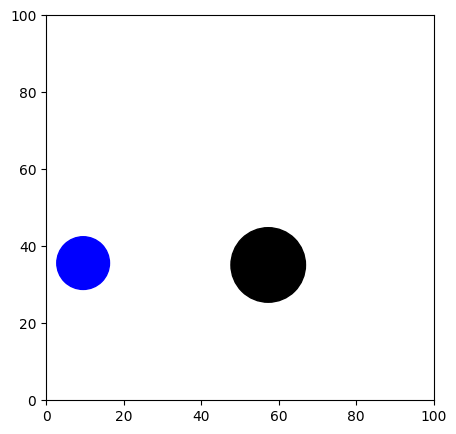

In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera

trial = 99
reward_trial = 3
target_x = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['x_target'].values[-1]
target_y = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['y_target'].values[-1]


x_data = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['x'].values[:100]
y_data = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['y'].values[:100]
states = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['state'].map({0:'blue',1:'orange'}).values
color = states

fig = plt.figure(figsize=[5, 5])
camera = Camera(fig)

# Raio das partículas de acordo com o tamanho da figura
points_whole_ax = 5 * 0.8 * 72    # 1 point = dpi / 72 pixels
radius = 0.05*L
points_radius = 2 * radius / 1.0 * points_whole_ax

ax = plt.axes(xlim=(0, L), ylim=(0, L))

for i in range(len(x_data)):
    plt.scatter(
        *np.array([[x_data[i],target_x], [y_data[i],target_y]]), 
        c=np.array([color[i],'black']), 
        s=[points_radius/2,points_radius]
    )
    camera.snap()

anim = camera.animate(blit=True)
anim.save(f'scatter_{trial}_{reward_trial}.gif', fps=10, dpi=200)

# Simulando multiplos agentes

In [62]:
import os
import sys
import numpy as np
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()

agent_list = os.listdir('agents')

print(agent_list)

sys.path.insert(0, 'agents')
sys.path.insert(0, 'environments')

['ps_agent_basic.py', 'ps_agent_flexible.py', '__pycache__']


In [137]:
import env_abp_target_finding as env_class
import ps_agent_basic as agent_class

L = 100

Pe = 100
#Pe = (v*tao)/L #Péclet number

l = 1
#l = v/(D_theta*L) #persistence of directed motion in ABP phase

dt = 1

tao = int(dt/10e-4)
#tao = L*L/(4*D)

param_dict = {
    5:{
        'gamma_damping' : 1e-7,
        'eta_glow_damping' : 1e-2
        },
    10:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    20:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    50:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-2
        },
    100:{
        'gamma_damping' : 1e-5,
        'eta_glow_damping' : 1e-2
        }
}

In [138]:
n_agentes = 100

#parameters for the agent - explanations can be found in the comments inside the agent file
gamma_damping = param_dict[Pe]['gamma_damping']
eta_glow_damping = param_dict[Pe]['eta_glow_damping']
policy_type = 'standard'# 'softmax' ou 'standard'
beta_softmax = 1
num_reflections =  0

#set number of trials and maximum number of steps in each trial
num_trials = 100
max_steps_per_trial = 20*tao

In [139]:
h_matrix = [] #guarda as probabilidades
statistics = [] #guarda os resultados do processo de aprendizado

for i_agente in range(n_agentes):
    
    env = env_class.TaskEnvironment(L, Pe, l, tao, dt)
    agent = agent_class.BasicPSAgent(
        env.num_actions, env.num_percepts_list,
        gamma_damping, eta_glow_damping, 
        policy_type, beta_softmax,
        num_reflections
    )

    for step in range(env.max_steps_per_trial):
        for state in range(env.num_states):
            percept = agent.percept_preprocess([state,step])
            if state == 0:
                agent.h_matrix[1, percept] = 1e-2
                agent.h_matrix[0, percept] = 1 - 1e-2

            elif state == 1:
                agent.h_matrix[1, percept] = 1e-3
                agent.h_matrix[0, percept] = 1 - 1e-3

    agent.h0_matrix = agent.h_matrix

    reward = 0 #temporarily stores the reward for the most recent action

    for i_trial in range(num_trials):
        
        reward_trial = 0 #additive counter of the total rewards earned during the current trial
        state_counter = 0 #conta qual estado ele está, considerando que a cada ação tomada vai para um novo estado
        reward_counter = 0 #conta quantos passos o agente demora para receber uma recompensa
        discretized_observation = env.reset() #reinicia a posição do target
        agent.g_matrix = np.zeros((agent.num_actions, agent.num_percepts), dtype=np.float64) #reinicia a matriz de movimentos
        
        for t in range(max_steps_per_trial):
            action = agent.deliberate(discretized_observation)
            discretized_observation, reward, done = env.move(action) #atualiza o ambiente
            reward_trial += reward #conta a recompensa
            agent.learn(reward)

            if done:
                statistics.append([i_trial, i_agente, t, reward, reward_trial])
                break
                
        if reward_trial > 0:
            print(i_agente, i_trial, reward_trial, t/reward_trial/tao)

    h_matrix.append([i_agente, h_matrix])    

0 0 1 7.661
0 1 1 0.004
0 2 1 5.869
0 3 1 1.241
0 4 1 5.137
0 5 1 8.093
0 6 1 0.008
0 7 1 2.19
0 8 1 0.759
0 9 1 0.007
0 10 1 3.997
0 11 1 2.791
0 12 1 0.967
0 13 1 0.132
0 14 1 3.318
0 15 1 5.942
0 16 1 2.351
0 17 1 0.461
0 18 1 0.005
0 19 1 1.832
0 20 1 4.266
0 21 1 3.914
0 22 1 0.213
0 23 1 5.767
0 24 1 5.01
0 25 1 0.941
0 26 1 0.61
0 27 1 0.216
0 28 1 1.511
0 29 1 0.596
0 30 1 0.754
0 31 1 3.363
0 32 1 0.706
0 33 1 1.558
0 34 1 0.141
0 35 1 2.865
0 36 1 0.989
0 37 1 2.477
0 38 1 0.146
0 39 1 1.679
0 40 1 0.278
0 41 1 1.401
0 42 1 0.679
0 43 1 0.307
0 44 1 2.884
0 45 1 0.572
0 46 1 0.225
0 47 1 0.411
0 48 1 1.449
0 49 1 2.366
0 50 1 0.029
0 51 1 0.003
0 52 1 1.374
0 53 1 0.108
0 54 1 5.768
0 55 1 1.973
0 56 1 0.009
0 57 1 0.248
0 58 1 0.964
0 59 1 0.004
0 60 1 0.551
0 61 1 3.3
0 62 1 0.054
0 63 1 4.156
0 64 1 2.178
0 65 1 2.154
0 66 1 0.177
0 67 1 0.859
0 68 1 0.414
0 69 1 1.328
0 70 1 1.522
0 71 1 0.762
0 72 1 1.182
0 73 1 3.7
0 74 1 5.702
0 75 1 1.139
0 76 1 0.42
0 77 1 1.086
0 78

KeyboardInterrupt: 

In [132]:
pd.DataFrame(statistics).to_csv('statistics.csv', index = False)
pd.DataFrame(h_matrix).to_csv('h_matrix.csv', index = False)

In [140]:
df = pd.DataFrame(statistics, columns = ['i_trial', 'i_agent', 't', 'reward','reward_trial'])
df = df[df['i_agent'] < 8].reset_index(drop = True)
#idx = df.groupby(['i_trial','i_agent'])['reward_trial'].idxmax().reset_index()['reward_trial']
#df = df.loc[idx].reset_index(drop = True) 
df['medida'] = df['t']/df['reward_trial']/tao
df.head()

,i_trial,i_agent,t,reward,reward_trial,medida
0,0,0,7661,1,1,7.661
1,1,0,4,1,1,0.004
2,2,0,5869,1,1,5.869
3,3,0,1241,1,1,1.241
4,4,0,5137,1,1,5.137


In [141]:
alt.Chart(df.groupby(['i_trial'])['medida'].mean().reset_index()).mark_line(color = 'red').encode(
    x = 'i_trial',
    y = 'medida'
)

alt.Chart(...)